# NEU502B Homework 4: Multivariate pattern analysis
*Due March 27, 2024*

*Submission instructions:* First, rename your homework notebook to include your name (e.g. `homework-4-nastase.ipynb`); keep your homework notebook in the `homework` directory of your clone of the class repository. Prior to submitting, restart the kernel and run all cells (see *Kernel* > *Restart Kernel and Run All Cells...*) to make sure your code runs and the figures render properly. Only include cells with necessary code or answers; don't include extra cells used for troubleshooting. To submit, `git add`, `git commit`, and `git push` your homework to your fork of the class repository, then make a pull request on GitHub to sync your homework into the class repository.

In this homework assignment, you will work through three commonly used methods in cognitive computational neuroscience: (1) neural decoding via multivariate pattern analysis (MVPA); (2) representational similarity analysis (RSA); and (3) voxelwise encoding analysis using regularized regression. Each of these problems builds on tools and ideas we've introduced in the in-class lab notebooks.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Problem 1: Multivariate pattern classification

First, we'll start with a simple example of classifying distributed response patterns for different object categories from [Haxby et al., 2001](https://doi.org/10.1126/science.1063736). We'll begin by loading in the data, as well as labels for the stimuli and runs. You'll need to change `data_dir` to a directory on your computer (or the server); if you've already downloaded this dataset in lab, you can set `data_dir` to the existing directory to save time.

In [6]:
from nilearn import datasets
from nilearn.image import index_img
import pandas as pd

# Change this path to a directory on your computer!
data_dir = '/Users/ak4601/Documents/neu502b/nilearn-data'

# Load the Haxby et al., 2001 data via Nilearn
haxby_dataset = datasets.fetch_haxby(data_dir=data_dir)

# Load in session metadata as pandas DataFrame
session = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

# Extract stimuli and run labels for this subject
stimuli, runs = session['labels'].values, session['chunks'].values

# Create a boolean array indexing TRs containing a stimulus (non-rest)
task_trs = stimuli != 'rest'

# Get list of unique stimulus categories (excluding rest)
categories = [c for c in np.unique(stimuli) if c != 'rest']

# Extract task TRs for fMRI data and stimulus/run labels
func_task = index_img(haxby_dataset.func[0], task_trs)
stimuli_task = stimuli[task_trs]
runs_task = runs[task_trs]

Use `NiftiMasker` (with `standardize=True`) to create a masker for ventral temporal (VT) cortex. Use the masker to extract the the NumPy array containing the functional data. (We'll analyze the data using scikit-learn rather than nilearn.)

In [13]:
# Get the VT mask file and creater masker:
from nilearn.maskers import NiftiMasker
vt_mask_file = haxby_dataset.mask_vt[0]
masker = NiftiMasker(mask_img=vt_mask_file, standardize=True)

# Uses masker to extract numpy array for VT:
masker.fit()
func_data_masked = masker.transform(func_task)  # (864, 464)

Now, we'll set up a full SVM classification analysis using leave-one-run-out outer cross-validation with a nested leave-one-run-out inner cross-validation loop for grid search across the values of the SVM regularization parameter $C$. Sounds like a lot! But scikit-learn makes it pretty straightforward. First, initialize the `LinearSVC` estimator. Since this well-behaved dataset has the same number of samples for each stimulus category in each run, we can perform leave-one-run-out cross-validation using just `KFold` rather than having to specify the runs directly. Initalize an outer `KFold` cross-validator with 12 splits and an inner `KFold` cross-validator with 11 splits. We'll search over a handful of $C$ parameters: `param_grid = {'C': [1e-2, 1e-1, 1]}`. Initialize the `GridSearchCV` estimator with the SVM estimator, the parameter grid, and the inner cross-validator; then, submit this estimator to `cross_val_predict` with the outer cross-validator to run the full analysis. (This may take a few minutes to run!)

In [15]:
# Suppress some warnings (e.g. SVM convergence) just to clean up output
import warnings
from sklearn.model_selection import (cross_val_predict,
                                     GridSearchCV,
                                     KFold)
from sklearn.svm import LinearSVC
warnings.filterwarnings("ignore")

# Initialize SVM and outer/inner CVs:
svc_estimator = LinearSVC()

# Set up parameter grid:
param_grid = {'C': [1e-2, 1e-1, 1]}

# Initialize outer KFold cross-validator with 12 splits
outer_cv = KFold(n_splits=12)

# Initialize inner KFold cross-validator with 11 splits
inner_cv = KFold(n_splits=11)

# Initialize GridSearchCV estimator:
grid_search = GridSearchCV(estimator=svc_estimator, param_grid=param_grid, cv=inner_cv)

# Generate predictions using cross_val_predict:
predicted = cross_val_predict(grid_search, X=func_data_masked, y=stimuli_task, cv=outer_cv)

Inspect the resulting predictions. We'll evaluate our classifier's predictions in two ways. First, use `accuracy_score` from `sklearn.metrics` to evaluate the predictions (across all test sets) against the actual labels in terms of a single classification accuracy. Procedurally, this is slightly different from computing accuracies on the test for each fold and averaging them—but the resulting value should be the same.

In [16]:
# Print accuracy score:
from sklearn.metrics import accuracy_score

# Compute accuracy score
accuracy = accuracy_score(y_true=stimuli_task, y_pred=predicted)

# Print accuracy score
print("Classification Accuracy:", accuracy)

Classification Accuracy: 0.7233796296296297


To better understand what our classifer is doing (i.e. what it's getting right and what it's getting wrong), we'll construct a confusion matrix. Construct the confusion matrix from the actual stimulus labels and the classifer's predicted labels and plot it below. What categories does the classifier tend to misclassify?

_The classifier tends to misclassify scissors, cats, and chairs._

<Figure size 1000x800 with 0 Axes>

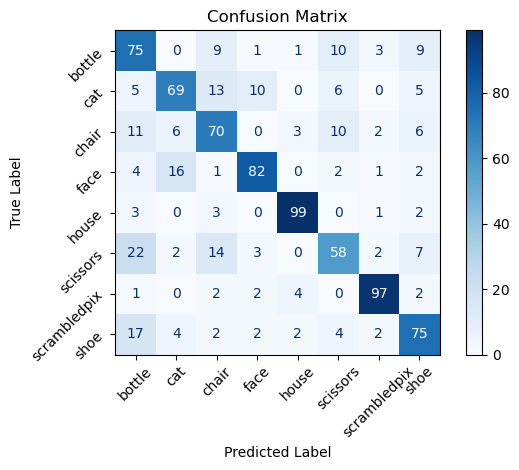

In [17]:
# Create confusion matrix from true and predicted labels:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix from true and predicted labels
conf_matrix = confusion_matrix(y_true=stimuli_task, y_pred=predicted, labels=categories)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=categories)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

Lastly, we'll repeat the same analysis for functional regions of interest (ROIs) maximally responsive to faces (roughly FFA) and houses (roughly PPA). Use the `mask_face` and `mask_house` files from the dataset to create an FFA masker and a PPA masker; extract the functional data for both. Submit these datasets to the same analysis as above, and visualize the results in terms of an overall accuracy score and confusion matrix. Interpret the accuracies and confusion matrices in light of the expected chance accuracy, given what you know about these ROIs.

_Chance accuracy is $\frac{1}{8}=12.5\%$. Overall accuracy for both FFA ($27.7\%$) and PPA ($51.4\%$) are above chance accuracy. The FFA classifier is particularly predictive for faces, with a classification accuracy of $\frac{67}{108}=62\%$. The FFA classifier also tends to misclassify cats as faces. $\frac{42}{108}=38.9\%$ of the cat stimuli were misclassified as faces. The PPA classifier is particularly predictive for houses, with a classification accuracy of $\frac{93}{108}=86.1\%$._

In [27]:
# Create masker for FFA:
ffa_mask_file = haxby_dataset.mask_face[0]
masker_ffa = NiftiMasker(mask_img=ffa_mask_file, standardize=True)
masker_ffa.fit()

# Create masker for PPA:
ppa_mask_file = haxby_dataset.mask_house[0]
masker_ppa = NiftiMasker(mask_img=ppa_mask_file, standardize=True)
masker_ppa.fit()

# Uses masker to extract numpy array for VT:
func_data_masked_ffa = masker_ffa.transform(func_task)
func_data_masked_ppa = masker_ppa.transform(func_task)

In [29]:
# Initialize SVM and outer/inner CVs:
svc_estimator = LinearSVC()

# Set up parameter grid:
param_grid = {'C': [1e-2, 1e-1, 1]}

# Initialize outer KFold cross-validator with 12 splits
outer_cv = KFold(n_splits=12)

# Initialize inner KFold cross-validator with 11 splits
inner_cv = KFold(n_splits=11)

# Initialize GridSearchCV estimator:
grid_search = GridSearchCV(estimator=svc_estimator, param_grid=param_grid, cv=inner_cv)

# Generate predictions using cross_val_predict:
predicted_ffa = cross_val_predict(grid_search, X=func_data_masked_ffa, y=stimuli_task, cv=outer_cv)

Accuracy Score for FFA: 0.27662037037037035


<Figure size 1000x800 with 0 Axes>

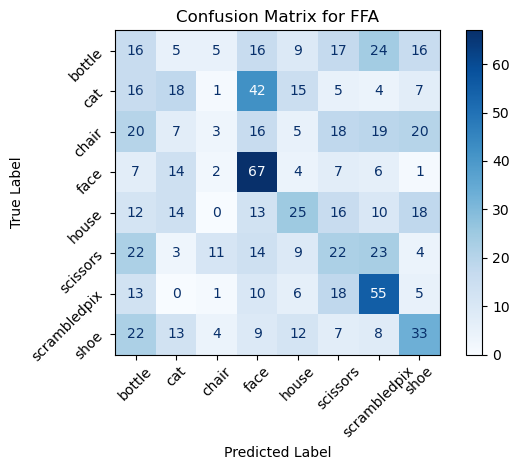

In [35]:
# Print accuracy score and plot confusion matrix:

# Compute accuracy score for FFA
accuracy_ffa = accuracy_score(y_true=stimuli_task, y_pred=predicted_ffa)

# Print accuracy scores for FFA
print("Accuracy Score for FFA:", accuracy_ffa)

# Create confusion matrix from true and predicted labels
conf_matrix_ffa = confusion_matrix(y_true=stimuli_task, y_pred=predicted_ffa, labels=categories)

# Plot confusion matrix for FFA
plt.figure(figsize=(10, 8))
disp_ffa = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ffa, display_labels=categories)
disp_ffa.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for FFA')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
# Initialize SVM and outer/inner CVs:
svc_estimator = LinearSVC()

# Set up parameter grid:
param_grid = {'C': [1e-2, 1e-1, 1]}

# Initialize outer KFold cross-validator with 12 splits
outer_cv = KFold(n_splits=12)

# Initialize inner KFold cross-validator with 11 splits
inner_cv = KFold(n_splits=11)

# Initialize GridSearchCV estimator:
grid_search = GridSearchCV(estimator=svc_estimator, param_grid=param_grid, cv=inner_cv)

# Generate predictions using cross_val_predict:
predicted_ppa = cross_val_predict(grid_search, X=func_data_masked_ppa, y=stimuli_task, cv=outer_cv)

Accuracy Score for PPA: 0.5138888888888888


<Figure size 1000x800 with 0 Axes>

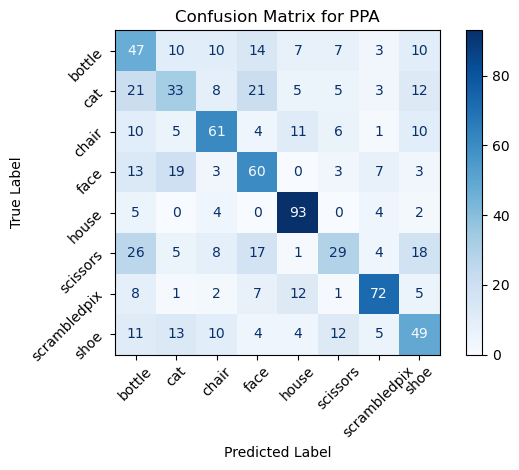

In [38]:
# Print accuracy score and plot confusion matrix:

# Compute accuracy score for PPA
accuracy_ppa = accuracy_score(y_true=stimuli_task, y_pred=predicted_ppa)

# Print accuracy scores for PPA
print("Accuracy Score for PPA:", accuracy_ppa)

# Create confusion matrix for PPA
conf_matrix_ppa = confusion_matrix(y_true=stimuli_task, y_pred=predicted_ppa, labels=categories)

# Plot confusion matrix for PPA
plt.figure(figsize=(10, 8))
disp_ppa = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ppa, display_labels=categories)
disp_ppa.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for PPA')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

### Problem 2: Representational similarity analysis

In this problem, we'll apply representational similarity analysis (RSA) to the human fMRI dataset from [Kriegeskorte et al., 2008](https://doi.org/10.1016/j.neuron.2008.10.043). We'll begin by loading in the ROI data and labels.

In [42]:
# Load in Kriegekorte dataset and labels
kriegeskorte_dataset = dict(np.load('kriegeskorte_dataset.npz',
                                    allow_pickle=True))

roi_data = kriegeskorte_dataset['roi_data'].item()
category_names = kriegeskorte_dataset['category_names']
category_labels = kriegeskorte_dataset['category_labels']
images = kriegeskorte_dataset['images']
subject_labels = ['KO', 'SN', 'TI']
roi_labels = ['lFFA', 'rFFA', 'lPPA', 'rPPA']

We provide a `rank_percentile` function for visualizing RDMs in a way that more closely matches the paper. 

In [43]:
from scipy.stats import rankdata

def rank_percentile(a):
    return rankdata(a) / len(a) * 100

First, compute RDMs for the `'lFFA'`, `'rFFA'`, `'lPPA'`, and `'rPPA'` ROIs for subject `'TI'` using correlation distance. Here, we recommend z-soring each voxel across samples prior to computing the pairwise dissimilarities. Plot the RDMs for each ROI using the `rank_percentile` function provided above.

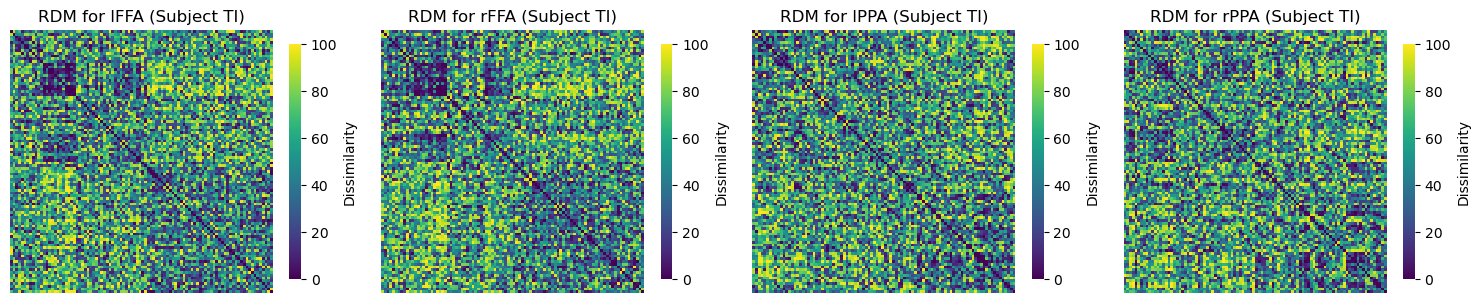

In [135]:
# Plot ROI RDMs for subject TI:
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform

# Calculate RDMs for each ROI for subject 'TI'
rdms_TI = {}
for roi_label in roi_labels:
    roi_data_TI = roi_data['TI'][roi_label]
    # Z-score each voxel across samples
    zscore_data = zscore(roi_data_TI, axis=0)
    # Compute pairwise correlation distance
    pairwise_dist = pdist(zscore_data, metric='correlation')
    # Compute rank percentiles
    rdms_TI[roi_label] = rank_percentile(pairwise_dist)

# Plot ROI RDMs for subject 'TI'
plt.figure(figsize=(15, 5))
for i, roi_label in enumerate(roi_labels):
    plt.subplot(1, 4, i+1)
    sns.heatmap(
        squareform(rdms_TI[roi_label]),
        square=True, 
        cmap='viridis', 
        xticklabels=False,
        yticklabels=False,
        cbar=True,
        cbar_kws=dict(label='Dissimilarity', shrink=0.5),
    )
    plt.title(f'RDM for {roi_label} (Subject TI)')
plt.tight_layout()
plt.show()

RSA allows us to compare the representational geometries of different ROIs. Compute the correlation between each pair of the four ROIs. Plot this similarity matrix. Which ROIs have the most similar representational geometries?

_rPPA and IPPA have similar representational geometries. rFFA and IFFA have similar representational geometries._

[[1.         0.24777964 0.07539158 0.0794637 ]
 [0.24777964 1.         0.10455463 0.13291925]
 [0.07539158 0.10455463 1.         0.17803334]
 [0.0794637  0.13291925 0.17803334 1.        ]]


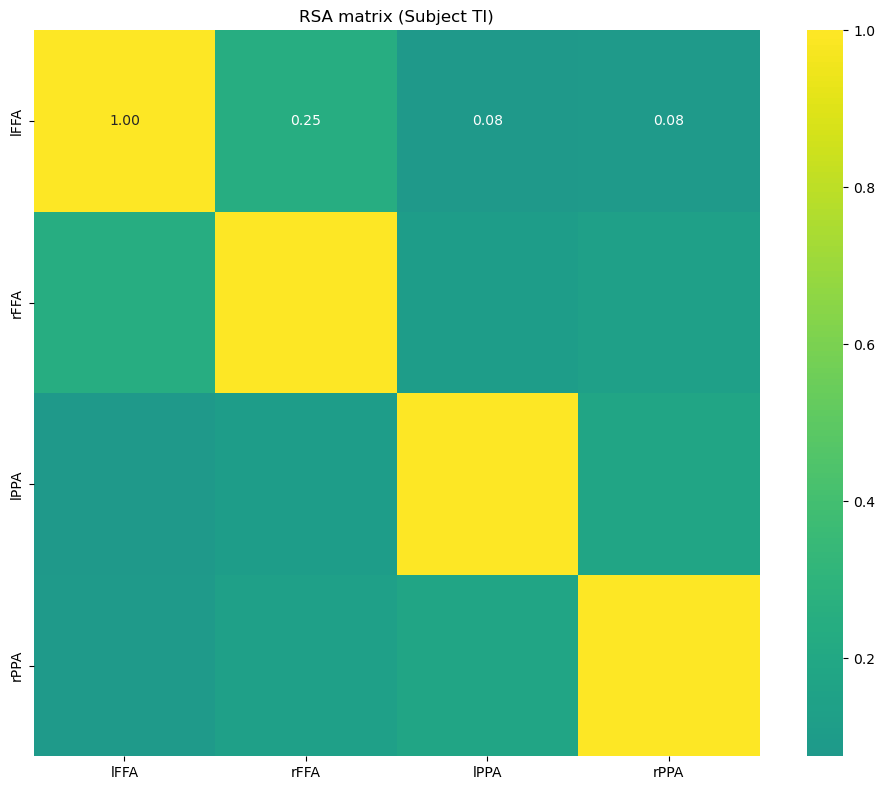

In [185]:
# Compute correlations between each pair or ROI RDMs:
from scipy.spatial.distance import correlation

stacked_rdms_TI = np.stack([rdms_TI[roi_label] for roi_label in roi_labels])
rsa_TI = np.corrcoef(stacked_rdms_TI)
print(rsa_TI)

# Plot correlation matrix:    
plt.figure(figsize=(10, 8))
sns.heatmap(
    rsa_TI,
    annot=True,
    fmt='.2f',
    xticklabels=roi_labels,
    yticklabels=roi_labels,
    center=0,
    square=True,
    cmap='viridis',
)
plt.title(f'RSA matrix (Subject TI)')
plt.tight_layout()
plt.show()

Stack all four ROIs to create a single combined ROI for each subject `'SN'` and `'TI'`. What is the Spearman correlation between `'SN'`'s and `'TI'`'s representational geometries?

_The Spearman correlation between between `'SN'`'s and `'TI'`'s representational geometries is 0.154._

In [170]:
# Combine SN and TI ROIs into single VT ROI and compute RDMs:
from scipy.stats import spearmanr

# Compute correlations between SN and TI's VT RDMs:
stacked_TI = zscore(np.concatenate([roi_data['TI'][roi_label] for roi_label in roi_labels], axis=-1), axis=0)
stacked_SN = zscore(np.concatenate([roi_data['SN'][roi_label] for roi_label in roi_labels], axis=-1), axis=0)

rdm_TI = rank_percentile(pdist(stacked_TI))
rdm_SN = rank_percentile(pdist(stacked_SN))

spearmanr(rdm_TI, rdm_SN)

SignificanceResult(statistic=0.15444882568757923, pvalue=9.630888300865469e-26)

We can test different "model" RDMs according to how well they approximate a given neural. Here, for the sake of brevity, we'll construct an extremely simple RDM capturing low-level visual structure. Flatten each image file into a one-dimensional array of pixel values (across three color channels). Next, compute the pairwise Euclidean distances between these image vectors to construct an RDM capture low-level visual similarities. Plot this pixel RDM and compute it's Spearman correlation with `'TI'`s VT RDM?

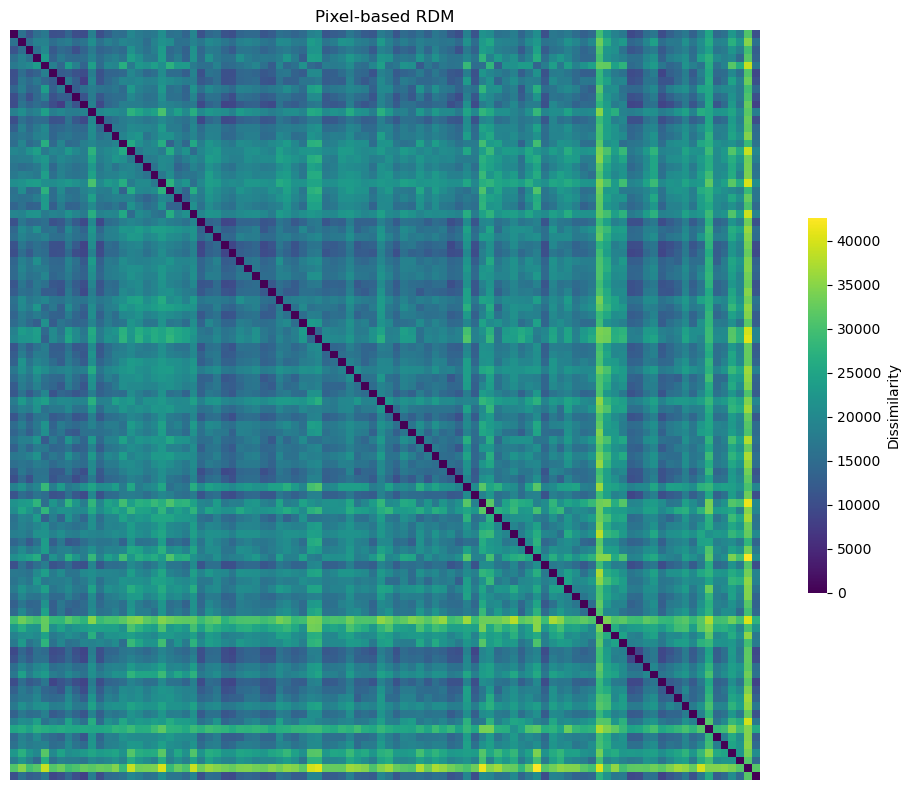

SignificanceResult(statistic=-0.05310461077848753, pvalue=0.0003337557397257462)

In [199]:
# Create a pixel-based RDM:
pixels = images.reshape(images.shape[0], -1)
rdm_pixels = pdist(pixels, metric='euclidean')

plt.figure(figsize=(10, 8))
sns.heatmap(
    squareform(rdm_pixels),
    square=True, 
    cmap='viridis', 
    xticklabels=False,
    yticklabels=False,
    cbar=True,
    cbar_kws=dict(label='Dissimilarity', shrink=0.5),
)
plt.title(f'Pixel-based RDM')
plt.tight_layout()
plt.show()

# Compute correlations with VT RDM:
spearmanr(rdm_pixels, rdm_TI)

### Problem 3: Voxelwise encoding analysis

In this problem, we'll return to *encoding analysis*, using regularized regression and out-of-sample prediction in individual voxels. We will use word embeddings derived from the natural language processing (NLP) model GloVe to map semantic encoding onto the brain. You can simply load the `story_transcript.txt` file in a text editor to visualize the transcript for the spoken story by [Carol Daniel](https://themoth.org/stories/i-knew-you-were-black). Each line of this file corresponds to a TR in the fMRI data. Next, we extracted word embeddings from GloVe for each word in each TR. For TRs containing multiple words, we averaged the embeddings. Finally, we horizontally stacked the embeddings at lags of 2, 3, 4, and 5 TRs (3, 4.5, 6, and 7.5 seconds relative to word onset) to account variable hemodynamic lags (this is effectively a finite impulse response model). Inspect and interpret the shape of the word embeddings, and visualize this matrix.

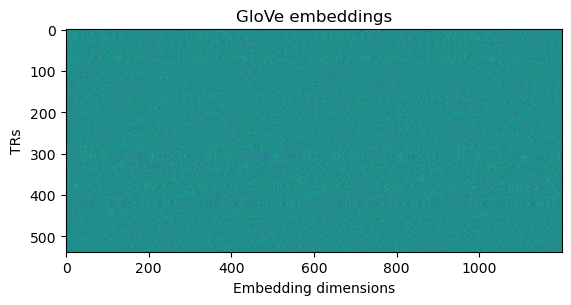

In [202]:
# Load and visualize word embeddings:
embeddings = np.load('story_embeddings.npy')
# Shape is (trs, embedding_dims) = (538, 1200)

plt.imshow(embeddings)
plt.title('GloVe embeddings')
plt.xlabel('Embedding dimensions')
plt.ylabel('TRs')
plt.show()

We used fMRI to measure a subject's brain activity while they listened to the spoken story. Here, to reduce computational demands, we have spatially downsampled the fMRI data using an atlas containing 400 parcels. That is, for each parcel, we averaged the voxel time series within that parcel. Rather than fitting encoding models to tens of thousands of voxels, we'll fit our encoding model to each of the 400 parcels. Load in the `story_parcels.npy` dataset as well as the `story_atlas.nii.gz` NIfTI image from which the parcels were derived (for later visualization).

In [206]:
# Load in parcel time series:
parcels = np.load('story_parcels.npy')
# Shape is (trs, parcels) = (538, 400)

# Load in the Schaefer 400-parcel atlas:
import nibabel as nib

atlas = nib.load('story_atlas.nii.gz')

Our word embedding "model" is much wider than the number of samples, so we'll need to use regularization and out-of-sample prediction to mitigate overfitting. We'll use ridge regression to fit encoding models to predict the parcel time series from the word embeddings. First, set up an split-half outer cross-validator using `KFold` with `n_splits=2`; next, set up an inner cross-validator using `KFold` with `n_splits=5` to perform grid search for the `alpha` hyperparameter using 5-fold cross-validation within each training set of the otuer loop. Initialize your `RidgeCV` estimator with the inner cross-validator and the following grid of alphas: `alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]`. For each training and testing split of the other cross-validation loop, fit the ridge model on the training set of embeddings and parcel time series, and generate predicted parcel time series from the test embeddings. Compile these predicted parcel time series for model evaluation in the next step:

In [218]:
# Set up outer/inner cross-validators:
from sklearn.model_selection import KFold

X = embeddings.copy()
y = parcels.copy()

outer_cv = KFold(n_splits=2)
inner_cv = KFold(n_splits=5)

# Initialize RidgeCV with alpha grid and inner CV:
from sklearn.linear_model import RidgeCV

alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
ridge_cv = RidgeCV(alphas=alphas, cv=inner_cv)

all_y_pred = []
all_y_test = []

# Loop through outer CV loop, fit model, generate predictions:
for train_indices, test_indices in outer_cv.split(X):
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    ridge_cv.fit(X_train, y_train)
    y_pred = ridge_cv.predict(X_test)
    
    all_y_test.append(y_test)
    all_y_pred.append(y_pred)

all_y_pred = np.concatenate(all_y_pred, axis=0)
all_y_test = np.concatenate(all_y_test, axis=0)

To evaluate our encoding model's predictions, correlate the predicted parcel time series with the actual parcel time series for each parcel. 

In [228]:
# Compute correlation between predicted and actual responses:
from scipy.stats import pearsonr

correlations = np.array([
    pearsonr(y_pred, y_test).statistic for y_pred, y_test in zip(all_y_pred.T, all_y_test.T)
])

Finally, to visualize the performance of our semantic encoding model on the brain, we need to use the atlast NIfTI image to convert from parcels back to the original brain image. You can start by creating an empty brain image (i.e. zeros) the size of the atlas image. Next, loop through each parcel and insert the prediction scores (i.e. correlations between actual and predicted parcel time series) into all voxels where the atlas correponds to that parcel label. Convert this image to a NIfTI image and visualize with `plot_stat_map`; you may want to set a particular `vmax` and use a `threshold` to exclude voxels with poor prediction performance for the sake of visualization.

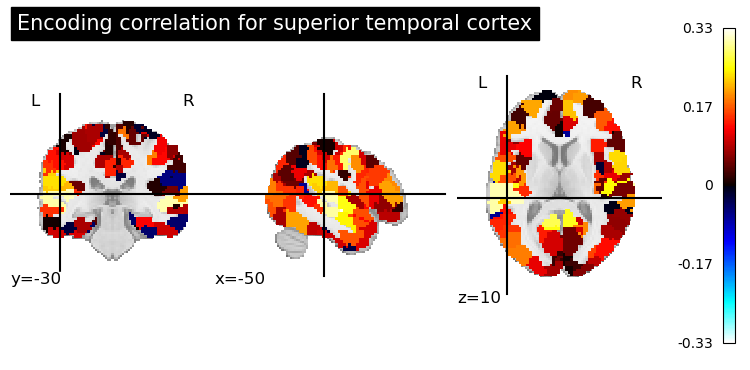

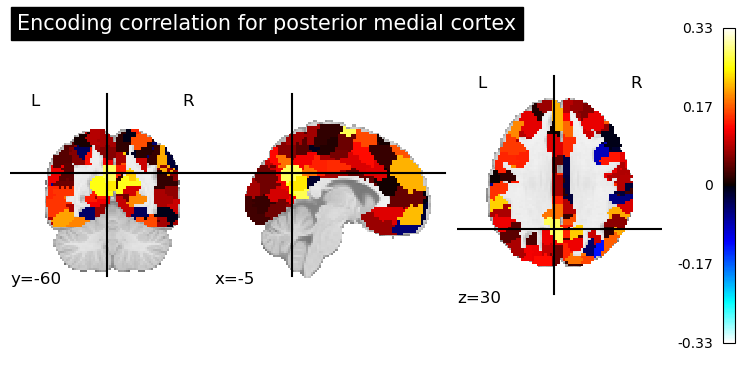

In [235]:
# Create an empty brain image and populate with parcelwise performance values:
from nilearn.plotting import plot_stat_map


# Convert to NIfTI image for visualization with Nilearn:
atlas_image = atlas.get_fdata()
brain_image = np.zeros_like(atlas_image)

for i, correlation in enumerate(correlations):
    parcel_mask = atlas_image == (i + 1)
    brain_image[parcel_mask] = correlation

brain_nifti = nib.Nifti1Image(brain_image, atlas.affine)

# Plot correlations to visualize superior temporal cortex:
plot_stat_map(brain_nifti, cut_coords=(-50, -30, 10), title='Encoding correlation for superior temporal cortex')

# Plot correlations to visualize posterior medial cortex:
plot_stat_map(brain_nifti, cut_coords=(-5, -60, 30), title='Encoding correlation for posterior medial cortex')